# permutation_importances as reusable function

## function code

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import numpy as np
import pandas as pd
import numbers

import sklearn
from sklearn.base import clone
from sklearn.utils import check_random_state

import matplotlib.pyplot as plt
import seaborn as sns

from cloudpickle import load

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model, PlotArtifact
from typing import Union, Callable, List

def _get_n_samples_bootstrap(n_samples, max_samples) -> int:
    """get the number of samples in a bootstrap sample
    
    returns the total number of samples to draw for the bootstrap sample
    
    private api in sklearn >= v0.24, taken from sklearn.ensemble._forest.py

    :param n_samples:   Number of samples in the dataset.
    :param max_samples: 
        The maximum number of samples to draw from the total available:
            - if float, this indicates a fraction of the total and should be
              the interval `(0, 1)`;
            - if int, this indicates the exact number of samples;
            - if None, this indicates the total number of samples.
    """
    if max_samples is None:
        return n_samples

    if isinstance(max_samples, numbers.Integral):
        if not (1 <= max_samples <= n_samples):
            msg = "`max_samples` must be in range 1 to {} but got value {}"
            raise ValueError(msg.format(n_samples, max_samples))
        return max_samples

    if isinstance(max_samples, numbers.Real):
        if not (0 < max_samples < 1):
            msg = "`max_samples` must be in range (0, 1) but got value {}"
            raise ValueError(msg.format(max_samples))
        return int(round(n_samples * max_samples))

    msg = "`max_samples` should be int or float, but got type '{}'"
    raise TypeError(msg.format(type(max_samples)))

def _get_unsampled_ix(random_state, n_samples: int) -> np.array:
    """
    future-proof get unsampled indices
    """
    n_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
    random_instance = check_random_state(random_state)
    sample_indices = random_instance.randint(0, n_samples, n_bootstrap)
    sample_counts = np.bincount(sample_indices, minlength=n_samples)

    return np.arange(n_samples)[sample_counts==0]

def _oob_classifier_accuracy(rf, X_train, y_train) -> float:
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn forest classifier.
    
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_ix(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    
    return oob_score

def permutation_importances(
    context: MLClientCtx,
    model: DataItem,
    dataset: DataItem,
    labels: str,
    figsz=(10, 5),
    plots_dest: str = "plots",
    fitype: str = "permute"
) -> pd.DataFrame:
    """calculate change in metric
    
    type 'permute' uses a pre-estimated model
    type 'dropcol' uses a re-estimates model
    
    :param context:     the function's execution context
    :param model:       a trained model
    :param dataset:     features and ground truths, regression targets
    :param labels       name of the ground truths column
    :param figsz:       matplotlib figure size
    :param plots_dest:  path within artifact store
    :
    """
    model_file, model_data, _ = get_model(model.url, suffix='.pkl')
    model = load(open(str(model_file), "rb"))
    
    X = dataset.as_df()
    y = X.pop(labels)
    header = X.columns
    
    # this will be paramettrized next version, and include regression
    metric = _oob_classifier_accuracy
    
    baseline = metric(model, X, y)
    
    imp = []
    for col in X.columns:
        if fitype is "permute":
            save = X[col].copy()
            X[col] = np.random.permutation(X[col])
            m = metric(model, X, y)
            X[col] = save
            imp.append(baseline - m)
        elif fitype is "dropcol":
            X_ = X.drop(col, axis=1)
            model_ = clone(model)
            model_.random_state = random_state
            model_.fit(X_, y)
            o = model_.oob_score_
            imp.append(baseline - o)
        else:
            raise ValueError("unknown fitype, only 'permute' or 'dropcol' permitted")

    # create a feature importance table with desired labels
    zipped = zip(imp, header)
    feature_imp = pd.DataFrame(sorted(zipped), columns=["importance", "feature"])
    feature_imp.sort_values(by="importance", ascending=False, inplace=True)

    plt.clf()
    plt.figure(figsize=figsz)
    sns.barplot(x="importance", y="feature", data=feature_imp)
    plt.title(f"feature importances-{fitype}")
    plt.tight_layout()

    context.log_artifact(PlotArtifact(f"feature importances-{fitype}", body=plt.gcf()),
                         local_path=f"{plots_dest}/feature-permutations.html")
    context.log_dataset(f"feature-importances-{fitype}-tbl", df=feature_imp, index=False)

In [3]:
# nuclio: end-code

## save function

In [4]:
from mlrun import code_to_function
from mlrun.platforms.other import auto_mount

gpus = False

# create job function object from notebook code
fn_params = {
    "name"        : "feature-perms",
    "handler"     : "permutation_importances",
    "kind"        : "job",
    "image"       : "mlrun/ml-models" if not gpus else "mlrun/ml-models-gpu",
    "description" : "estimate feature importances using permutations",
    "categories"  : ["analysis"],
    "labels"      : {"author": "yjb"}
}

perms_fn = code_to_function(**fn_params)
perms_fn.apply(auto_mount())
perms_fn.export("function.yaml")

[mlrun] 2020-06-07 19:58:25,298 function spec saved to path: function.yaml


## tests

In [5]:
from mlrun import import_function
from mlrun import NewTask, mlconf

#### get some data

In [6]:
data_url = "https://raw.githubusercontent.com/parrt/random-forest-importances/master/notebooks/data/rent.csv"

fn = import_function("hub://arc_to_parquet", "a2p")
fn.apply(auto_mount())

params = {
    "name" : "tasks arc-to-parq",
    "params" : {"key":"rent", "stats": True, "file_ext":"csv"}
}
acquire_run = fn.run(NewTask(**params),inputs={"archive_url" : data_url},
                     artifact_path=mlconf.artifact_path)

[mlrun] 2020-06-07 19:58:25,352 starting run tasks arc-to-parq uid=e9bc67f2189c418d96bfde754d369956  -> http://mlrun-api:8080
[mlrun] 2020-06-07 19:58:25,486 Job is running in the background, pod: tasks-arc-to-parq-xqkr7
[mlrun] 2020-06-07 19:58:29,118 starting local run: main.py # arc_to_parquet
[mlrun] 2020-06-07 19:58:29,169 downloading https://raw.githubusercontent.com/parrt/random-forest-importances/master/notebooks/data/rent.csv to local tmp
[mlrun] 2020-06-07 19:58:29,535 destination file does not exist, downloading
[mlrun] 2020-06-07 19:58:29,898 log artifact rent at /User/artifacts/rent.csv, size: 1492462, db: Y

[mlrun] 2020-06-07 19:58:29,917 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...4d369956,0,Jun 07 19:58:29,completed,tasks arc-to-parq,v3io_user=adminkind=jobowner=adminhost=tasks-arc-to-parq-xqkr7,archive_url,key=rentstats=Truefile_ext=csv,,rent


to track results use .show() or .logs() or in CLI: 
!mlrun get run e9bc67f2189c418d96bfde754d369956 --project default , !mlrun logs e9bc67f2189c418d96bfde754d369956 --project default
[mlrun] 2020-06-07 19:58:31,666 run executed, status=completed


#### train a model

In [7]:
fn = import_function("hub://sklearn_classifier", "skrf")
fn.apply(auto_mount())

# define model
params = {
    "name" : "tasks random forest",
    "params" : {
        "sample"                 : -5_000, # 5k random rows,
        "model_pkg_class"        : "sklearn.ensemble.RandomForestClassifier",
        "label_column"           : "interest_level",
        "CLASS_n_estimators"     : 100,
        "CLASS_min_samples_leaf" : 1,
        "CLASS_n_jobs"           : -1,
        "CLASS_oob_score"        : True}
}

train_run = fn.run(NewTask(**params), inputs={"dataset" : acquire_run.outputs["rent"]},
                   artifact_path=mlconf.artifact_path)

[mlrun] 2020-06-07 19:58:31,704 starting run tasks random forest uid=57af834167264641905a5bb5e6b0e263  -> http://mlrun-api:8080
[mlrun] 2020-06-07 19:58:31,861 Job is running in the background, pod: tasks-random-forest-vkjk5
[mlrun] 2020-06-07 19:58:35,390 starting local run: main.py # train_model
[mlrun] 2020-06-07 19:58:36,310 log artifact test_set at /User/artifacts/data/test_set.parquet, size: 24484, db: Y
[mlrun] 2020-06-07 19:58:37,153 log artifact confusion-matrix at /User/artifacts/model/plots/confusion-matrix.html, size: 27401, db: N
[mlrun] 2020-06-07 19:58:37,598 log artifact feature-importances at /User/artifacts/model/plots/feature-importances.html, size: 19685, db: N
[mlrun] 2020-06-07 19:58:37,806 log artifact precision-recall-multiclass at /User/artifacts/model/plots/precision-recall-multiclass.html, size: 74009, db: N
[mlrun] 2020-06-07 19:58:37,936 log artifact roc-multiclass at /User/artifacts/model/plots/roc-multiclass.html, size: 73053, db: N
[mlrun] 2020-06-07 19:

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...e6b0e263,0,Jun 07 19:58:36,completed,tasks random forest,v3io_user=adminkind=jobowner=adminhost=tasks-random-forest-vkjk5class=sklearn.ensemble.RandomForestClassifier,dataset,sample=-5000model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=interest_levelCLASS_n_estimators=100CLASS_min_samples_leaf=1CLASS_n_jobs=-1CLASS_oob_score=True,test-accuracy=0.6902857142857143test-error=0.3097142857142857auc-micro=0.8567196734693878auc-weighted=0.7077200281488216f1-score=0.44361444815007395precision_score=0.4969837043184901recall_score=0.42733978329897576,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 57af834167264641905a5bb5e6b0e263 --project default , !mlrun logs 57af834167264641905a5bb5e6b0e263 --project default
[mlrun] 2020-06-07 19:58:41,115 run executed, status=completed



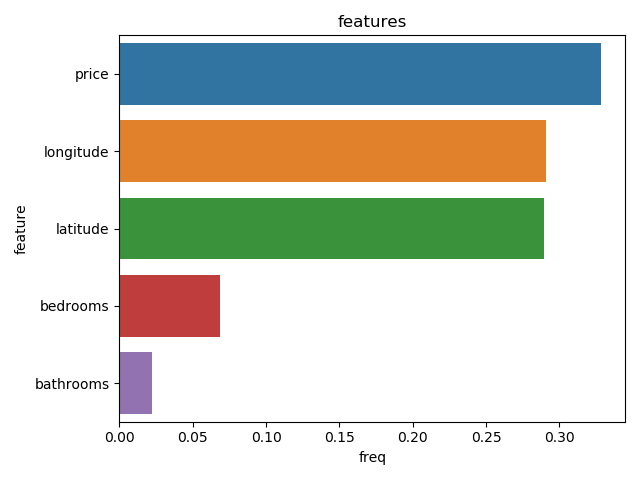

In [8]:
from IPython.display import HTML
HTML(filename=train_run.outputs['feature-importances'])

In [9]:
data   = acquire_run.outputs["rent"]
labels = "interest_level"
model  = train_run.outputs["model"]


In [10]:
fi_perms = perms_fn.run(
    NewTask(params={"labels": labels, 
                    "plots_dest": "plots"}),
    inputs={"model": model, "dataset": data},
    artifact_path=mlconf.artifact_path)

[mlrun] 2020-06-07 19:58:41,152 starting run features-permutation_importances uid=89235b15ac2a4213aefc906c178a1c5e  -> http://mlrun-api:8080
[mlrun] 2020-06-07 19:58:41,312 Job is running in the background, pod: features-permutation-importances-dwxmt
[mlrun] 2020-06-07 19:58:44,871 starting local run: main.py # permutation_importances
[mlrun] 2020-06-07 19:58:48,714 log artifact feature importances-permute at /User/artifacts/plots/feature-permutations.html, size: 25694, db: Y
[mlrun] 2020-06-07 19:58:48,770 log artifact feature-importances-permute-tbl at /User/artifacts/feature-importances-permute-tbl.csv, size: 167, db: Y

[mlrun] 2020-06-07 19:58:48,785 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...178a1c5e,0,Jun 07 19:58:45,completed,features-permutation_importances,v3io_user=adminkind=jobowner=adminhost=features-permutation-importances-dwxmt,modeldataset,labels=interest_levelplots_dest=plots,,feature importances-permutefeature-importances-permute-tbl


to track results use .show() or .logs() or in CLI: 
!mlrun get run 89235b15ac2a4213aefc906c178a1c5e --project default , !mlrun logs 89235b15ac2a4213aefc906c178a1c5e --project default
[mlrun] 2020-06-07 19:58:50,488 run executed, status=completed



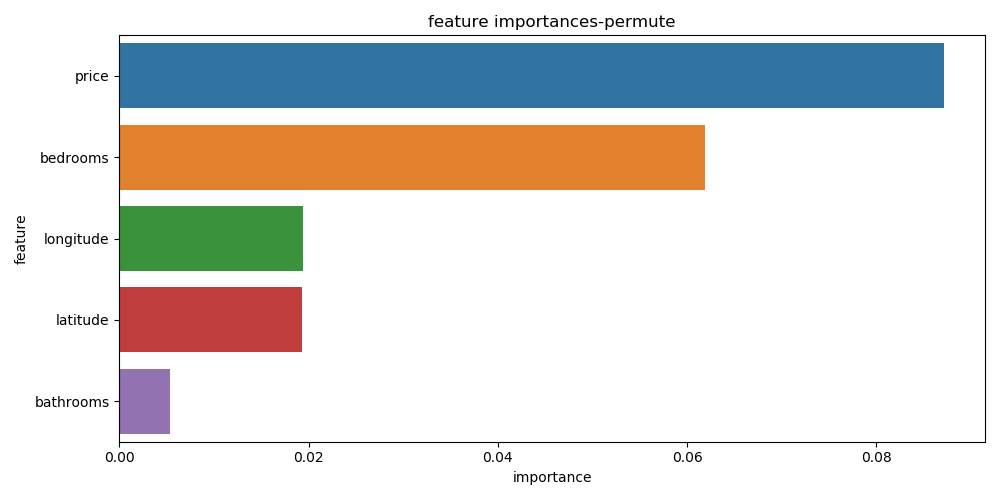

In [11]:
from IPython.display import HTML
HTML(filename=fi_perms.outputs['feature importances-permute'])